In [28]:
import pandas as pd
from datetime import date, datetime
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import roc_auc_score, f1_score, roc_curve, precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.utils import resample, shuffle

SEED = 2031995

In [29]:
!pip install catboost

In [30]:
from catboost import CatBoostClassifier

## 1. Первичный анализ, кодирование пациентов

In [31]:
df = pd.read_excel('death.xlsx')

In [32]:
columns = df.columns

In [33]:
print('Кол-во объектов в столбце ID:', len(df['ID']))
print('Кол-во уникальных объектов в столбце ID:', len(df['ID'].unique()))
# очевидно, что столбец ID не несет уникальные идентификаторы

Кол-во объектов в столбце ID: 886
Кол-во уникальных объектов в столбце ID: 145


In [34]:
df = df.reset_index(drop=False)
df = df.drop([columns[2], 'ID'], axis=1)

In [35]:
print('Всего объеков в name:', len(df['Name']))
print('Уникальных объектов в name:', len(df['Name'].unique()))

Всего объеков в name: 886
Уникальных объектов в name: 886


Имена не дублируются, дубликатов пациентов нет, можно удалить столбец,предварительно сохранив шифр ID-Имя

In [36]:
decoding_names = pd.DataFrame(df['index'])
decoding_names['name'] = df['Name']
decoding_names.columns = ['id', 'name']

In [37]:
print(decoding_names.shape)
print(decoding_names.columns) #если потребуется расшифровать каждого пациента

(886, 2)
Index(['id', 'name'], dtype='object')


In [38]:
df = df.drop(['Name'], axis=1)

In [39]:
df['Op. Year'] = pd.to_datetime(df['Op. Year'], format='%Y.%m.%d')
df['Death'] = pd.to_datetime(df['Death'], format='%Y.%m.%d')

In [40]:
#df.to_excel('death_data.xlsx')
print('Уникальных признаков:', len(df.columns), ', включая пре-, интра- и пост- опперационные')

Уникальных признаков: 238 , включая пре-, интра- и пост- опперационные


 ## 2. Предобработка
 ### 2.1 Пропуски

In [41]:
## рейтинг пропусков
df_nas = pd.DataFrame(df.isna().sum(), columns=['NA_num'])
df_nas['NA_percent'] = (df_nas['NA_num']/len(df)*100).round(2)
display(df_nas.sort_values(by='NA_percent'))

,NA_num,NA_percent
index,0,0.0
Op. Year,0,0.0
Рост,0,0.0
Other then isolated,0,0.0
Операция на грудной аорте,0,0.0
...,...,...
Unnamed: 238,886,100.0
#ECG,886,100.0
SF36,886,100.0
Unnamed: 233,886,100.0


In [42]:
## пустые столбцы
print('Кол-во столбцов с пропусками: {} из {}'.format(len(df_nas.loc[df_nas['NA_percent'] > 0]), len(df_nas)))
print('Кол-во столбцов с пропусками 0 - 5%:', len(df_nas.query('NA_percent >= 0 & NA_percent < 5')))
print('Кол-во столбцов с пропусками более 10%:', len(df_nas.query('NA_percent > 10')))

Кол-во столбцов с пропусками: 188 из 238
Кол-во столбцов с пропусками 0 - 5%: 97
Кол-во столбцов с пропусками более 10%: 112


In [43]:
print('shape df до чистки:', df.shape)

shape df до чистки: (886, 238)


In [44]:
## малая доля пропусков, можно удалить
columns_to_del = df_nas.query('NA_percent > 10').index
columns_to_dropna = df_nas.query('NA_percent > 0 & NA_percent < 10').index

На следующий этап привлекаются столбцы с долей пропусков менее 10%.

In [45]:
df_clear = df.drop(columns_to_del, axis=1)

In [46]:
print('shape df после чистки:', df_clear.shape)

shape df после чистки: (886, 126)


## Оценка стат значимости

### Чистка от опечаток
#### Функции
- str_transform - перевод в numeric. Применялась в поиске строковых опечаток в каждом столбце.
- show_mistapes - считает опечатки
- show_strange - показывает некорректное значение
- update_column_names - выбрасывает измененный стобец для корректного отобращения в слчае обращения по номеру столбца
- unique_categories - вытаскивает уникальные категории столбца для дальнейшего ohe преобразования
- ohe_for_col - создает столбцы по категориям каждого признака для ohe.

Я доставала каждый класс каждого признака, чтобы в последствии выбрать один из коллинеарных, даже если классов всего два (да/нет).

In [47]:
def str_transform(column_name):
    df_clear[column_name] = pd.to_numeric(df_clear[column_name])

In [48]:
def show_mistapes(df, column_name, misprint_data):
    #print()
    print('Кол-во опечаток вида {} в {}'.format(misprint_data, column_name), len(df.loc[df[column_name] == misprint_data]))

def show_strange(df, err_index, column_name):
    print()
    print('Некорректное значение:', df.loc[df.index == err_index, [column_name]])
    #return df.loc[df.index == err_index, [columns_names[column_num]]]

In [49]:
def update_columns_names():
    columns_names = df_clear.drop(['is_death'], axis=1).columns
    return columns_names

### Преобразование строчных категорий

In [50]:
def unique_categories(col):
    #print(column)
    unique_in = col.dropna().unique()
    unique_out=[]
    for string in unique_in:
        #unique_out=[]
        #print(string)
        #string.strip()
        #print(unique_out)
        unique_out.append(string.strip())
        #print(pd.Series(unique_out))
    unique = pd.Series(unique_out).unique()
    #print(unique)
    return unique

def ohe_for_col(row, cat, col_name):
    target_column = row[col_name]
    
    if target_column == np.nan:
        row[col_name + '_' + cat] = np.nan
    elif target_column == cat:
        row[col_name + '_' + cat] = 1
    else:
        row[col_name + '_' + cat] = 0
    return row[col_name + '_' +cat]
    


In [51]:
## Sex
df_clear['male'] = np.nan
df_clear.loc[df_clear['Sex'] == 'М', 'male'] = 1
df_clear.loc[df_clear['Sex'] == 'Ж', 'male'] = 0
df_clear = df_clear.drop(['Sex'], axis=1)

## Smoking
df_clear.loc[df_clear['Smoking'] == 'Да', 'Smoking'] = 1
df_clear.loc[df_clear['Smoking'] == ' Да', 'Smoking'] = 1
df_clear.loc[df_clear['Smoking'] == 'Нет', 'Smoking'] = 0
df_clear.loc[df_clear['Smoking'] == ' Нет', 'Smoking'] = 0
df_clear.loc[df_clear['Smoking'] == 'Нет ', 'Smoking'] = 0
str_transform('Smoking')

## UnderlyingDisease #расшифровка UnderlyingDIsease
UnderlyingDisease_unique = df_clear['UnderlyingDisease'].unique()
df_clear.loc[df_clear['UnderlyingDisease'] == 'I24.8', 'UnderlyingDisease'] = 1
df_clear.loc[df_clear['UnderlyingDisease'] == 'I20.8', 'UnderlyingDisease'] = 2
df_clear.loc[df_clear['UnderlyingDisease'] == 'I20.0', 'UnderlyingDisease'] = 2
df_clear.loc[df_clear['UnderlyingDisease'] == 'I24.8 ', 'UnderlyingDisease'] = 1
df_clear.loc[df_clear['UnderlyingDisease'] == 'I21.9', 'UnderlyingDisease'] = 3
df_clear.loc[df_clear['UnderlyingDisease'] == 'I21.0', 'UnderlyingDisease'] = 3
df_clear.loc[df_clear['UnderlyingDisease'] == 'I20.8 ', 'UnderlyingDisease'] = 2
df_clear.loc[df_clear['UnderlyingDisease'] == 'I25.8', 'UnderlyingDisease'] = 4
df_clear.loc[df_clear['UnderlyingDisease'] == 'I25', 'UnderlyingDisease'] = 4
df_clear.loc[df_clear['UnderlyingDisease'] == 'I21.1', 'UnderlyingDisease'] = 3
df_clear.loc[df_clear['UnderlyingDisease'] == 'I21.4', 'UnderlyingDisease'] = 3
df_clear.loc[df_clear['UnderlyingDisease'] == 'I20.9', 'UnderlyingDisease'] = 2
df_clear.loc[df_clear['UnderlyingDisease'] == 'I35.0', 'UnderlyingDisease'] = 5
df_clear.loc[df_clear['UnderlyingDisease'] == 'I25.1', 'UnderlyingDisease'] = 4
df_clear.loc[df_clear['UnderlyingDisease'] == 'I20.1', 'UnderlyingDisease'] = 2


# I50Stage
unique = unique_categories(df_clear['I50Stage'])
for cat in unique:
    df_clear['I50Stage_' + cat] = np.nan
    df_clear['I50Stage_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'I50Stage'))
df_clear = df_clear.drop(['I50Stage'], axis=1)
columns_names = update_columns_names

# I50Class
unique = unique_categories(df_clear['I50Class'])
for cat in unique:
    df_clear['I50Class_' + cat] = np.nan
    df_clear['I50Class_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'I50Class'))
df_clear = df_clear.drop(['I50Class'], axis=1)
columns_names = update_columns_names

# I20
unique = unique_categories(df_clear['I20'])
for cat in unique:
    df_clear['I20_' + cat] = np.nan
    df_clear['I20_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'I20'))
df_clear = df_clear.drop(['I20'], axis=1)
columns_names = update_columns_names

In [52]:
# J44

df_clear.loc[df_clear['J44'] == 'Нет', 'J44'] = 0
df_clear.loc[df_clear['J44'] == 'Да', 'J44'] = 1

# E11
unique = unique_categories(df_clear['E11'])
for cat in unique:
    df_clear['E11_' + cat] = np.nan
    df_clear['E11_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'E11'))
df_clear = df_clear.drop(['E11'], axis=1)
columns_names = update_columns_names

# N18
unique = unique_categories(df_clear['N18'])
for cat in unique:
    df_clear['N18_' + cat] = np.nan
    df_clear['N18_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'N18'))
df_clear = df_clear.drop(['N18'], axis=1)
columns_names = update_columns_names

# I63
unique = unique_categories(df_clear['I63'])
for cat in unique:
    df_clear['I63_' + cat] = np.nan
    df_clear['I63_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'I63'))
df_clear = df_clear.drop(['I63'], axis=1)
columns_names = update_columns_names

# K26
unique = unique_categories(df_clear['K26'])
for cat in unique:
    df_clear['K26_' + cat] = np.nan
    df_clear['K26_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'K26'))
df_clear = df_clear.drop(['K26'], axis=1)
columns_names = update_columns_names

# N20
unique = unique_categories(df_clear['N20'])
for cat in unique:
    df_clear['N20_' + cat] = np.nan
    df_clear['N20_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'N20'))
df_clear = df_clear.drop(['N20'], axis=1)
columns_names = update_columns_names

# K80.1
unique = unique_categories(df_clear['K80.1'])
for cat in unique:
    df_clear['K80.1_' + cat] = np.nan
    df_clear['K80.1_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'K80.1'))
df_clear = df_clear.drop(['K80.1'], axis=1)
columns_names = update_columns_names

# I48.0-I48.9 (b) ФИБРИЛЛЯЦИЯ ДО ОПЕРАЦИИ 

df_clear['fibrillation_b'] = np.nan
df_clear.loc[df_clear['I48.0-I48.9 (b)'] == 'Нет', 'fibrillation_b'] = 0
df_clear.loc[df_clear['I48.0-I48.9 (b)'] == 'I48.2', 'fibrillation_b'] = 1
df_clear.loc[df_clear['I48.0-I48.9 (b)'] == 'I48.0', 'fibrillation_b'] = 1
df_clear.loc[df_clear['I48.0-I48.9 (b)'] == 'I48.1', 'fibrillation_b'] = 1
df_clear.loc[df_clear['I48.0-I48.9 (b)'] == 'I48.3', 'fibrillation_b'] = 1
df_clear = df_clear.drop(['I48.0-I48.9 (b)'], axis=1)

# I48.0-I48.9 (а) ФИБРИЛЛЯЦИЯ ПОСЛЕ ОПЕРАЦИИ
df_clear['fibrillation_a'] = np.nan
df_clear.loc[df_clear['I48.0-I48.9 (а)'] == 'Нет', 'fibrillation_a'] = 0
df_clear.loc[df_clear['I48.0-I48.9 (а)'] == 'I48.2', 'fibrillation_a'] = 1
df_clear.loc[df_clear['I48.0-I48.9 (а)'] == 'I48.0', 'fibrillation_a'] = 1
df_clear.loc[df_clear['I48.0-I48.9 (а)'] == 'I48.1', 'fibrillation_a'] = 1
df_clear.loc[df_clear['I48.0-I48.9 (а)'] == 'I48.3', 'fibrillation_a'] = 1
df_clear.loc[df_clear['I48.0-I48.9 (а)'] == 'I48.4', 'fibrillation_a'] = 1
df_clear.loc[df_clear['I48.0-I48.9 (а)'] == 'I48.9', 'fibrillation_a'] = 1
df_clear = df_clear.drop(['I48.0-I48.9 (а)'], axis=1)

# Op.time - добавить категории
df_clear.loc[df_clear['Op.time'] == '\n', 'Op.time'] = np.nan
str_transform('Op.time')

# Complications пока удалим 
df_clear = df_clear.drop(['Complications'], axis=1)
columns_names = update_columns_names

In [53]:
# лимфоциты1
df_clear.loc[df_clear['лимфоциты1'] == '\n', 'лимфоциты1'] = np.nan
str_transform('лимфоциты1')

# Op.Year пока удалим
df_clear = df_clear.drop(['Op. Year'], axis=1)
columns_names = update_columns_names

# ФП
unique = unique_categories(df_clear['ФП'])
for cat in unique:
    df_clear['ФП_' + cat] = np.nan
    df_clear['ФП_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'ФП'))
df_clear = df_clear.drop(['ФП'], axis=1)
columns_names = update_columns_names

# АВ-блокаДа
unique = unique_categories(df_clear['АВ-блокаДа'])
for cat in unique:
    df_clear['АВ-блокаДа_' + cat] = np.nan
    df_clear['АВ-блокаДа_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'АВ-блокаДа'))
df_clear = df_clear.drop(['АВ-блокаДа'], axis=1)
columns_names = update_columns_names

# Инфаркт миокарДа
df_clear.loc[df_clear['Инфаркт миокарДа'] == 'н', 'Инфаркт миокарДа'] = 'Нет'
unique = unique_categories(df_clear['Инфаркт миокарДа'])
for cat in unique:
    df_clear['Инфаркт миокарДа_' + cat] = np.nan
    df_clear['Инфаркт миокарДа_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'Инфаркт миокарДа'))
df_clear = df_clear.drop(['Инфаркт миокарДа'], axis=1)
columns_names = update_columns_names

# Фибрилляция Желудочков
unique = unique_categories(df_clear['Фибрилляция желудочков'])
for cat in unique:
    df_clear['Фибрилляция желудочков_' + cat] = np.nan
    df_clear['Фибрилляция желудочков_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'Фибрилляция желудочков'))
df_clear = df_clear.drop(['Фибрилляция желудочков'], axis=1)
columns_names = update_columns_names

# Асистолия.1
unique = unique_categories(df_clear['Асистолия.1'])
for cat in unique:
    df_clear['Асистолия.1_' + cat] = np.nan
    df_clear['Асистолия.1_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'Асистолия.1'))
df_clear = df_clear.drop(['Асистолия.1'], axis=1)
columns_names = update_columns_names

#  Кровотечение из послеоперационной раны
unique = unique_categories(df_clear['Кровотечение из послеоперационной раны'])
for cat in unique:
    df_clear['Кровотечение из послеоперационной раны_' + cat] = np.nan
    df_clear['Кровотечение из послеоперационной раны_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'Кровотечение из послеоперационной раны'))
df_clear = df_clear.drop(['Кровотечение из послеоперационной раны'], axis=1)
columns_names = update_columns_names

#  ДВС-синдром
unique = unique_categories(df_clear['ДВС-синдром'])
for cat in unique:
    df_clear['ДВС-синдром_' + cat] = np.nan
    df_clear['ДВС-синдром_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'ДВС-синдром'))
df_clear = df_clear.drop(['ДВС-синдром'], axis=1)
columns_names = update_columns_names

#  Пневмония
unique = unique_categories(df_clear['Пневмония'])
for cat in unique:
    df_clear['Пневмония_' + cat] = np.nan
    df_clear['Пневмония_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'Пневмония'))
df_clear = df_clear.drop(['Пневмония'], axis=1)
columns_names = update_columns_names

#  ЭкссуДативный плеврит
unique = unique_categories(df_clear['ЭкссуДативный плеврит'])
for cat in unique:
    df_clear['ЭкссуДативный плеврит_' + cat] = np.nan
    df_clear['ЭкссуДативный плеврит_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'ЭкссуДативный плеврит'))
df_clear = df_clear.drop(['ЭкссуДативный плеврит'], axis=1)
columns_names = update_columns_names

#  отек легких
unique = unique_categories(df_clear['отек легких'])
for cat in unique:
    df_clear['отек легких_' + cat] = np.nan
    df_clear['отек легких_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'отек легких'))
df_clear = df_clear.drop(['отек легких'], axis=1)
columns_names = update_columns_names

#  Инфекция раны
unique = unique_categories(df_clear['Инфекция раны'])
for cat in unique:
    df_clear['Инфекция раны_' + cat] = np.nan
    df_clear['Инфекция раны_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'Инфекция раны'))
df_clear = df_clear.drop(['Инфекция раны'], axis=1)
columns_names = update_columns_names

#  Медиастинит
unique = unique_categories(df_clear['Медиастинит'])
for cat in unique:
    df_clear['Медиастинит_' + cat] = np.nan
    df_clear['Медиастинит_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'Медиастинит'))
df_clear = df_clear.drop(['Медиастинит'], axis=1)
columns_names = update_columns_names

#  Инсульт
unique = unique_categories(df_clear['Инсульт'])
for cat in unique:
    df_clear['Инсульт_' + cat] = np.nan
    df_clear['Инсульт_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'Инсульт'))
df_clear = df_clear.drop(['Инсульт'], axis=1)
columns_names = update_columns_names

#  ТЭЛА
unique = unique_categories(df_clear['ТЭЛА'])
for cat in unique:
    df_clear['ТЭЛА_' + cat] = np.nan
    df_clear['ТЭЛА_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'ТЭЛА'))
df_clear = df_clear.drop(['ТЭЛА'], axis=1)
columns_names = update_columns_names

In [54]:
#  ДРСВ
unique = unique_categories(df_clear['ДРСВ'])
for cat in unique:
    df_clear['ДРСВ_' + cat] = np.nan
    df_clear['ДРСВ_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'ДРСВ'))
df_clear = df_clear.drop(['ДРСВ'], axis=1)
columns_names = update_columns_names

#  Экстракардиальная артериопатия
df_clear.loc[df_clear['Экстракардиальная артериопатия'] == 'Да', 'Экстракардиальная артериопатия'] = 1
df_clear.loc[df_clear['Экстракардиальная артериопатия'] == 'Нет', 'Экстракардиальная артериопатия'] = 0

#  Плохая мобильность
df_clear.loc[df_clear['Плохая мобильность'] == 'Да', 'Плохая мобильность'] = 1
df_clear.loc[df_clear['Плохая мобильность'] == 'Нет', 'Плохая мобильность'] = 0

# Операция на сердце в анамнезе
df_clear.loc[df_clear['Операция на сердце в анамнезе'] == 'Да', 'Операция на сердце в анамнезе'] = 1
df_clear.loc[df_clear['Операция на сердце в анамнезе'] == 'Нет', 'Операция на сердце в анамнезе'] = 0

# ХОБЛ
unique = unique_categories(df_clear['ХОБЛ'])
for cat in unique:
    df_clear['ХОБЛ_' + cat] = np.nan
    df_clear['ХОБЛ_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'ХОБЛ'))
df_clear = df_clear.drop(['ХОБЛ'], axis=1)
columns_names = update_columns_names

# Активный эндокардит
df_clear.loc[df_clear['Активный эндокардит'] == 'Да', 'Активный эндокардит'] = 1
df_clear.loc[df_clear['Активный эндокардит'] == 'Нет', 'Активный эндокардит'] = 0

# Критическое предоперационное состояние
df_clear.loc[df_clear['Критическое предоперационное состояние'] == 'Да', 'Критическое предоперационное состояние'] = 1
df_clear.loc[df_clear['Критическое предоперационное состояние'] == 'Нет', 'Критическое предоперационное состояние'] = 0

# Диабет
unique = unique_categories(df_clear['Диабет'])
for cat in unique:
    df_clear['Диабет_' + cat] = np.nan
    df_clear['Диабет_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'Диабет'))
df_clear = df_clear.drop(['Диабет'], axis=1)
columns_names = update_columns_names

# I50class уже было - пока удаляю
df_clear = df_clear.drop(['I50class'], axis=1)
columns_names = update_columns_names

# I20 IV FK - ЧТО???
df_clear = df_clear.drop(['I20 IV FK'], axis=1)
columns_names = update_columns_names

# НеДавний ИМ
df_clear.loc[df_clear['НеДавний ИМ'] == 'НЕт', 'НеДавний ИМ'] = 'Нет'
unique = unique_categories(df_clear['НеДавний ИМ'])
for cat in unique:
    df_clear['НеДавний ИМ_' + cat] = np.nan
    df_clear['НеДавний ИМ_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'НеДавний ИМ'))
df_clear = df_clear.drop(['НеДавний ИМ'], axis=1)
columns_names = update_columns_names

# Срочность
unique = unique_categories(df_clear['Срочность'])
for cat in unique:
    df_clear['Срочность_' + cat] = np.nan
    df_clear['Срочность_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'Срочность'))
df_clear = df_clear.drop(['Срочность'], axis=1)
columns_names = update_columns_names

# Other then isolated нерелевант удаляю
df_clear = df_clear.drop(['Other then isolated '], axis=1)
columns_names = update_columns_names

# Операция на грудной аорте - все одинаковое удаляю
df_clear = df_clear.drop(['Операция на грудной аорте'], axis=1)
columns_names = update_columns_names

# Постинфарктный разрыв - все одинаковое удаляю
df_clear = df_clear.drop(['Постинфарктный разрыв'], axis=1)
columns_names = update_columns_names

# Диализ

df_clear.loc[df_clear['Диализ'] == 'Да', 'Диализ'] = 1
df_clear.loc[df_clear['Диализ'] == 'Нет', 'Диализ'] = 0

# Аортальный стеноз
df_clear.loc[df_clear['Аортальный стеноз'] == 1, 'Аортальный стеноз'] = 'Да'
df_clear.loc[df_clear['Аортальный стеноз'] == 'легкий', 'Аортальный стеноз'] = 'Да'
df_clear.loc[df_clear['Аортальный стеноз'] == 'умеренный', 'Аортальный стеноз'] = 'Да'
df_clear.loc[df_clear['Аортальный стеноз'] == 'тяжелый', 'Аортальный стеноз'] = 'Да'
unique = unique_categories(df_clear['Аортальный стеноз'])
for cat in unique:
    df_clear['Аортальный стеноз_' + cat] = np.nan
    df_clear['Аортальный стеноз_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'Аортальный стеноз'))
df_clear = df_clear.drop(['Аортальный стеноз'], axis=1)
columns_names = update_columns_names

# Недостаточность аортального клапана
df_clear.loc[df_clear['Недостаточность аортального клапана'] == 1, 'Недостаточность аортального клапана'] = 'Да'
df_clear.loc[df_clear['Недостаточность аортального клапана'] == 2, 'Недостаточность аортального клапана'] = 'Да'
unique = unique_categories(df_clear['Недостаточность аортального клапана'])
for cat in unique:
    df_clear['Недостаточность аортального клапана_' + cat] = np.nan
    df_clear['Недостаточность аортального клапана_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'Недостаточность аортального клапана'))
df_clear = df_clear.drop(['Недостаточность аортального клапана'], axis=1)
columns_names = update_columns_names

# Недостаточность митрального клапана
df_clear.loc[df_clear['Недостаточность митрального клапана'] == 1, 'Недостаточность митрального клапана'] = 'Да'
df_clear.loc[df_clear['Недостаточность митрального клапана'] == 2, 'Недостаточность митрального клапана'] = 'Да'
df_clear.loc[df_clear['Недостаточность митрального клапана'] == 3, 'Недостаточность митрального клапана'] = 'Да'
unique = unique_categories(df_clear['Недостаточность митрального клапана'])
for cat in unique:
    df_clear['Недостаточность митрального клапана_' + cat] = np.nan
    df_clear['Недостаточность митрального клапана_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'Недостаточность митрального клапана'))
df_clear = df_clear.drop(['Недостаточность митрального клапана'], axis=1)
columns_names = update_columns_names

# Недостаточность трикуспидального клапана
df_clear.loc[df_clear['Недостаточность трикуспиДального клапана'] == 1, 'Недостаточность трикуспиДального клапана'] = 'Да'
df_clear.loc[df_clear['Недостаточность трикуспиДального клапана'] == 2, 'Недостаточность трикуспиДального клапана'] = 'Да'
df_clear.loc[df_clear['Недостаточность трикуспиДального клапана'] == 3, 'Недостаточность трикуспиДального клапана'] = 'Да'
unique = unique_categories(df_clear['Недостаточность трикуспиДального клапана'])
for cat in unique:
    df_clear['Недостаточность трикуспиДального клапана_' + cat] = np.nan
    df_clear['Недостаточность трикуспиДального клапана_' + cat] = df_clear.apply(ohe_for_col, axis=1, args=(cat, 'Недостаточность трикуспиДального клапана'))
df_clear = df_clear.drop(['Недостаточность трикуспиДального клапана'], axis=1)
columns_names = update_columns_names

# Исходно
df_clear.loc[df_clear['Исходно'] == 'СР', 'Исходно'] = np.nan
df_clear['Исходно'] = df_clear['Исходно'].fillna(df_clear['Исходно'].median())
str_transform('Исходно')

In [55]:
### Пост редакт с категориями

#I11Stage
df_clear.loc[df_clear['I11Stage'] == 2, 'I11Stage'] = 1
df_clear.loc[df_clear['I11Stage'] == 3, 'I11Stage'] = 1
df_clear.loc[df_clear['I11Stage'] == 4, 'I11Stage'] = 1

#I11Risk
df_clear.loc[df_clear['I11Risk'] == 2, 'I11Risk'] = 1
df_clear.loc[df_clear['I11Risk'] == 3, 'I11Risk'] = 1
df_clear.loc[df_clear['I11Risk'] == 4, 'I11Risk'] = 1


 ## 2. Feature Selection

In [56]:
print(df_clear['fibrillation_a'].value_counts())
print(df_clear['fibrillation_b'].value_counts())

0.0    667
1.0    218
Name: fibrillation_a, dtype: int64
0.0    801
1.0     85
Name: fibrillation_b, dtype: int64


I48.0-I48.9 (b) - до операции before
I48.0-I48.9 (a) - после операции after

In [57]:
df_clear_f = df_clear.query('fibrillation_b == 0')
print(df_clear.shape)
print(df_clear_f.shape)

control = df_clear_f[df_clear_f['fibrillation_a'] == 0].index
disease = df_clear_f[df_clear_f['fibrillation_a'] == 1].index

(886, 157)
(801, 157)


In [58]:
pv = pd.Series()

<ipython-input-58-6fa5a3851156>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pv = pd.Series()


In [60]:
dupl_feats_ohe = ['Недостаточность трикуспиДального клапана_Нет',
                  'Асистолия.1_Нет', 'Инфаркт миокарДа_Нет', 'Инсульт_Нет',
                  'Фибрилляция желудочков_Нет', 'Аортальный стеноз_Нет', 'K80.1_Нет',
                  'Недостаточность митрального клапана_Нет', 'ДВС-синдром_Нет', 
                  'ТЭЛА_Нет', 'ФП_Нет', 'Исходно', 'Креатинин2', 'QRS', 'QT', 'CCI', 'Билирубин общий2',
                  'Диастолического АД (после операции в реанимации)', 'EF%(a)', 'PQ', 'Unnamed: 239',
                  'Систолическое АД (после операции в реанимации)', 'Продолжительность операции',
                  'Недостаточность аортального клапана_Нет', 'ДВС-синдром_Да', 'ТЭЛА_Да', 'Пневмония_Да', 'Пневмония_Нет',
                  'отек легких_Да', 'ХОБЛ_Да', 'ХОБЛ_Нет', 'ЭкссуДативный плеврит_Нет', 'ЭкссуДативный плеврит_Да',
                  'ХОБЛ_Да', 'ХОБЛ_Нет', 'Инфекция раны_Да', 'Инфекция раны_Нет', 'Инфекция раны_Нет', 
                  'Инфекция раны_Да', 'ДРСВ_Нет', 'ДРСВ_Да', 'АЛАТ2', 'ЭкссуДативный плеврит_Нет',
                  'ЭкссуДативный плеврит_Да', 'Лейк2', 'Lymp#2', 'Диабет_Нет', 'RR', 'K26_Нет', 'АСАТ2',
                  'отек легких_Нет', 'Моноциты2', 'лимфоциты2', 'Время пережатия аорты', 'ИК длительность', 
                  'E11_Нет', 'Асистолия.1_Да', 'B.transf', 'I63_Нет', 'Фибрилляция желудочков_Да', 'P',
                  'Кровотечение из послеоперационной раны_Нет', 'E11_Да', 'НеДавний ИМ_Нет', 'N18_Нет', 'N20_Нет',
                  'Медиастинит_Нет', 'АВ-блокаДа_Нет', 'Медиастинит_Нет', 'Медиастинит_Да', 'АВ-блокаДа_Да','Lym#1',
                  'Глюкоза2', 'male', 'Диализ'

                 ]

df_clear_f = df_clear_f.drop(dupl_feats_ohe, axis=1)

In [61]:
df_clear_f = df_clear_f.drop(['index', 'IDTEST'], axis=1)

In [62]:
df_clear_f = pd.DataFrame(df_clear_f)

In [63]:
max_num_col = len(df_clear_f.drop(['fibrillation_a'], axis=1).columns)

for feat, num in zip(df_clear_f.drop(['fibrillation_a'], axis=1).columns, range(0, max_num_col)):
    print(num, feat, np.round(stats.ttest_ind(df_clear_f.loc[control, feat].dropna(), df_clear_f.loc[disease, feat].dropna()), 6)[1]) #отладочная строка
    #print(df_clear.loc[control, feat], df_clear.loc[disease, feat])
    pv[feat] = stats.ttest_ind(df_clear_f.loc[control, feat], df_clear_f.loc[disease, feat])[1]
    
topfeats = pv.sort_values()[1:28].index


#

0 Age 0.001384
1 Smoking 0.012027
2 SmokeIndex 0.361129
3 UnderlyingDisease 0.448786
4 I11Stage 0.115373
5 I11Risk 0.115373
6 J44 0.670912
7 EF%(b) 0.138655
8 EDD 0.261821
9 ESD 0.073023
10 PWT 0.491455
11 ST 0.690499
12 RVAW 0.533021
13 PAP 0.75932
14 RV 0.034387
15 LA3 0.101266
16 LA1 0.151764
17 LA2 0.083483
18 LAVolume 0.659076
19 Op.time 0.313072
20 Bypass# 0.754338
21 Лейк1 0.275849
22 Тромбоциты1 0.736589
23 палочки1 0.30709
24 сегментоядерные1 0.302635
25 лимфоциты1 0.225816
26 Hb2 0.908918
27 Эр2 0.958412
28 Тромбоциты2 0.94518
29 СОЭ2 0.778852
30 палочки2 0.984036
31 сегментоядерные2 0.85916
32 Мочевина2 0.957216
33 Рост 0.660474
34 Экстракардиальная артериопатия 0.109201
35 Плохая мобильность nan
36 Операция на сердце в анамнезе 0.578675
37 Активный эндокардит nan
38 Критическое предоперационное состояние nan
39 Систолическое АД (до операции) 0.706547
40 Диастолического АД (до операции) 0.366276
41 ЧСС (до операции) 0.28571
42 ЧСС (после операции в реанимации) 0.398935
43 «д

In [64]:
topfeats = topfeats.drop(['I50Class_IVFK', 'I50Class_IFK'])

In [65]:
#### классификация по numeric/categoric
def cat_or_numeric_data(df):
    feat_type = []
    
    for col in df.columns:
        cat_num = len(df[col].value_counts())

        if cat_num > 10:
            feat_type.append('num')
        else:
            feat_type.append('cat')
            
    return feat_type

#con_df = pd.DataFrame(index=)
#con_df.index = df_clear_f.columns
#con_df['feat_type'] = cat_or_numeric_data(df_clear_f)

### сводная
pivot = pd.DataFrame(index=df_clear_f.columns, columns=['non-POAF','std non-POAF', 'POAF', 'std POAF', 'p-value', 'feat_type']) #здесь еще было min, max,  но убрала (среднего и стд достаточно)
pivot['feat_type'] = cat_or_numeric_data(df_clear_f)


pivot = pivot.reset_index(drop=False)
#display(pivot)
def fill_pivot(row):
    #print(row['index'])
    feat = row['index']
    
    if row['feat_type'] == 'num':
        #row['min'] = df_clear_f[feat].min()
        #row['max'] = df_clear_f[feat].max()
        row['non-POAF'] = np.round(df_clear_f.loc[control, feat].mean(), 2)
        row['std non-POAF'] = np.round(np.std(df_clear_f.loc[control, feat]), 2)
        row['POAF'] = np.round(df_clear_f.loc[disease, feat].mean(), 2)
        row['std POAF'] = np.round(np.std(df_clear_f.loc[disease, feat]), 2)
        row['p-value'] = np. round(stats.ttest_ind(df_clear_f.loc[control, feat], df_clear_f.loc[disease, feat])[1], 2)
        return row
    else:
        #row['min'] = np.nan
        #row['max'] = np.nan
        row['non-POAF'] = np.round(df_clear_f.loc[control, feat].value_counts().index[0], 2)
        row['POAF'] = np.round(df_clear_f.loc[disease, feat].value_counts().index[0], 2)
        row['p-value'] = np.round(stats.ttest_ind(df_clear_f.loc[control, feat], df_clear_f.loc[disease, feat])[1], 2)
        return row    

In [66]:
pivot = pivot.apply(fill_pivot, axis=1)
#pivot = pivot.loc[:, 'index' : 'p-value']
#print(pivot_sorted_numeric)

In [67]:
pivot_sorted = pivot.sort_values('p-value')
pivot_sorted_numeric = pivot_sorted.query('feat_type == "num"')

#for feat in df_clear_f
#pivot_sorted_numeric_topfeats = pivot_sorted_numeric.[end_indexes_num]
#print(pivot[topfeats.T])

In [68]:
pivot

,index,non-POAF,std non-POAF,POAF,std POAF,p-value,feat_type
0,Age,62.38,7.66,64.55,6.58,0.00,num
1,Smoking,0.00,NaN,0.00,NaN,0.01,cat
2,SmokeIndex,10.49,17.90,9.01,17.81,NaN,num
3,UnderlyingDisease,2.00,NaN,2.00,NaN,0.45,cat
4,I11Stage,1.00,NaN,1.00,NaN,NaN,cat
...,...,...,...,...,...,...,...
82,Срочность_urgent,0.00,NaN,0.00,NaN,0.05,cat
83,Аортальный стеноз_Да,0.00,NaN,0.00,NaN,0.66,cat
84,Недостаточность аортального клапана_Да,0.00,NaN,0.00,NaN,0.68,cat
85,Недостаточность митрального клапана_Да,0.00,NaN,0.00,NaN,0.24,cat


In [1216]:
### функции ручного заполнения
#### Должны были использоваться для оформления результатов по каждой feature,  но не потребовалось
def show_num_feat(col_ind):
    print('Имя', df_clear_f.columns[col_ind])
    print('Расшифровка')
    print('Min', df_clear_f[df_clear_f.columns[col_ind]].min())
    print('Max', df_clear_f[df_clear_f.columns[col_ind]].max())
    print('Mean', np.round(df_clear_f[df_clear_f.columns[col_ind]].mean(), 3))
    print('Median', df_clear_f[df_clear_f.columns[col_ind]].median())
    print('p-value', np.round(stats.ttest_ind(df_clear_f.loc[control, df_clear_f.columns[col_ind]].dropna(), 
                                     df_clear_f.loc[disease, df_clear_f.columns[col_ind]].dropna())[1], 5))
    print()
    print('отладочные')
    print('пропуски', df_clear_f[df_clear_f.columns[col_ind]].isna().sum())
    
    
def show_cat_feat(col_ind):
    print('Имя', df_clear_f.columns[col_ind])
    print('Расшифровка')
    print('Категории', df_clear_f[df_clear_f.columns[col_ind]].value_counts())
    print('p-value', np.round(stats.ttest_ind(df_clear_f.loc[control, df_clear_f.columns[col_ind]].dropna(), 
                                     df_clear_f.loc[disease, df_clear_f.columns[col_ind]].dropna())[1], 5))
    print()
    print('пропуски', df_clear_f[df_clear_f.columns[col_ind]].isna().sum())
    
    
def num_or_cat(col_ind):
    cat_num = len(df_clear_f[df_clear_f.columns[col_ind]].value_counts())
    if cat_num > 15:
        print('numeric')
    else:
        print('categoric')
        
    

In [1221]:
num_or_cat(18)

numeric


In [1222]:
show_num_feat(18)

Имя LAVolume
Расшифровка
Min 0.0
Max 151.075872
Mean 30.148
Median 29.41352
p-value 0.65908

отладочные
пропуски 0


In [1223]:
show_cat_feat(11)

Имя ST
Расшифровка
Категории 1.00    191
1.10    157
1.20     97
1.30     67
0.90     63
0.80     40
1.40     36
1.50     23
0.70     11
1.60      8
1.16      6
1.70      5
1.23      5
1.29      3
1.80      2
1.45      2
0.60      1
1.90      1
1.28      1
1.17      1
1.70      1
0.60      1
1.12      1
1.11      1
1.26      1
1.24      1
1.87      1
1.25      1
2.00      1
1.36      1
1.22      1
Name: ST, dtype: int64
p-value 0.6905

пропуски 70


## 3. ML

In [69]:
df_selected_f = df_clear_f[topfeats]
df_selected_f['fibrillation_a'] = df_clear_f['fibrillation_a']
print('Длина fibrillation_a в selected',len(df_selected_f['fibrillation_a']))
print('Длина fibrillation_a в clear', len(df_clear_f['fibrillation_a']))

Длина fibrillation_a в selected 801
Длина fibrillation_a в clear 801


<ipython-input-69-2cff8bdbe9f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected_f['fibrillation_a'] = df_clear_f['fibrillation_a']


In [70]:
df_selected_f = df_selected_f.dropna()

In [71]:
X = df_selected_f.drop(['fibrillation_a'], axis=1)
y = df_selected_f['fibrillation_a']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=SEED)

In [72]:
X_train.shape

(640, 25)

(801, 250) --> (640, 25), так как
1. Были отобраны только предоперационные факторы
2. Были отобраны только статистически значимые факторы
3. Были отобраны только столбцы без пропусков

In [73]:
RegModel = LogisticRegression()
RegModel.fit(X_train, y_train)
y_proba = RegModel.predict_proba(X_test)
y_pred = RegModel.predict(X_test)

/Users/polinabezrukavaja/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [74]:
print('ROC-AUC Regression soft output', roc_auc_score(y_test, y_proba[:,1]))
print('ROC-AUC Regression hard output', roc_auc_score(y_test, y_pred))

ROC-AUC Regression soft output 0.7655841731989548
ROC-AUC Regression hard output 0.5156774916013437


In [75]:
RFModel = RandomForestClassifier(random_state=SEED, 
                       n_estimators=50, 
                       max_depth=5)
RFModel.fit(X_train, y_train)
y_proba = RFModel.predict_proba(X_test)
y_pred = RFModel.predict(X_test)

In [76]:
print('ROC-AUC unvalidated Forest soft output', roc_auc_score(y_test, y_proba[:,1]))
print('ROC-AUC unvalidated Forest hard output', roc_auc_score(y_test, y_pred))

ROC-AUC unvalidated Forest soft output 0.8936170212765957
ROC-AUC unvalidated Forest hard output 0.5


In [77]:
CatBoostModel = CatBoostClassifier(random_state=SEED)
CatBoostModel.fit(X_train, y_train)
y_proba = CatBoostModel.predict_proba(X_test)
y_pred = CatBoostModel.predict(X_test)

Learning rate set to 0.008515
0:	learn: 0.6891504	total: 63.5ms	remaining: 1m 3s
1:	learn: 0.6854861	total: 65.3ms	remaining: 32.6s
2:	learn: 0.6820294	total: 68ms	remaining: 22.6s
3:	learn: 0.6785371	total: 69.6ms	remaining: 17.3s
4:	learn: 0.6751490	total: 71.3ms	remaining: 14.2s
5:	learn: 0.6716981	total: 72.8ms	remaining: 12.1s
6:	learn: 0.6672228	total: 74.8ms	remaining: 10.6s
7:	learn: 0.6637386	total: 76.3ms	remaining: 9.46s
8:	learn: 0.6598902	total: 78ms	remaining: 8.59s
9:	learn: 0.6559845	total: 80.4ms	remaining: 7.96s
10:	learn: 0.6519582	total: 82.5ms	remaining: 7.42s
11:	learn: 0.6484935	total: 84.7ms	remaining: 6.98s
12:	learn: 0.6454061	total: 86.7ms	remaining: 6.58s
13:	learn: 0.6414743	total: 88.5ms	remaining: 6.24s
14:	learn: 0.6380197	total: 90.4ms	remaining: 5.93s
15:	learn: 0.6344297	total: 92.2ms	remaining: 5.67s
16:	learn: 0.6293121	total: 94ms	remaining: 5.44s
17:	learn: 0.6256257	total: 95.9ms	remaining: 5.23s
18:	learn: 0.6229506	total: 97.7ms	remaining: 5.04

In [78]:
print('ROC-AUC unvalidated Catboost soft output', roc_auc_score(y_test, y_proba[:,1]))
print('ROC-AUC unvalidated Catboost hard output', roc_auc_score(y_test, y_pred))

ROC-AUC unvalidated Catboost soft output 0.9134005225830534
ROC-AUC unvalidated Catboost hard output 0.7069802164986935


In [79]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

In [80]:
#pipe = Pipeline([('model', RandomForestClassifier(random_state=SEED))])
pipe = Pipeline([('model', LogisticRegression())])

params = [
    {
        #'model': [RandomForestClassifier(random_state=SEED, verbose=True)],
        #'model__max_features': ['auto', 20, 'none', 'log2'], 
        #'model__n_estimators': range(30, 211, 10),
        #'model__max_depth': range(6, 20, 2),
        #'model__criterion': ['gini', 'entropy']
    #}, {
        'model': [LogisticRegression(random_state=SEED, verbose=True)],
        'model__C': np.linspace(0.1, 1, 5),
        'model__class_weight': ['balanced', None],
        'model__solver': ['lbfgs', 'liblinear', 'sag'],
        'model__penalty': ['l1', 'l2']
    }]

### CatBoost запускала отдельно тк n_jobs и очень долго

In [81]:
testModel = GridSearchCV(pipe,
                         param_grid=params,
                         cv=cv,
                         scoring='roc_auc',
                         verbose=True,
                         n_jobs=3)

In [82]:
%time
testModel.fit(X, y)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.34 µs
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 185 tasks      | elapsed:    2.0s


[LibLinear]

[Parallel(n_jobs=3)]: Done 600 out of 600 | elapsed:    4.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2031995, shuffle=True),
             estimator=Pipeline(steps=[('model', LogisticRegression())]),
             n_jobs=3,
             param_grid=[{'model': [LogisticRegression(class_weight='balanced',
                                                       penalty='l1',
                                                       random_state=2031995,
                                                       solver='liblinear',
                                                       verbose=True)],
                          'model__C': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                          'model__class_weight': ['balanced', None],
                          'model__penalty': ['l1', 'l2'],
                          'model__solver': ['lbfgs', 'liblinear', 'sag']}],
             scoring='roc_auc', verbose=True)

In [83]:
print(testModel.best_score_)
print(testModel.best_params_)

0.6716980168269231
{'model': LogisticRegression(class_weight='balanced', penalty='l1', random_state=2031995,
                   solver='liblinear', verbose=True), 'model__C': 1.0, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'model__solver': 'liblinear'}


In [84]:
#model_fi = LogisticRegression(class_weight='balanced',
#                               penalty='l1',
#                               random_state=SEED,
#                               solver='liblinear',
#                               C=1.0,
#                              )
model_fi = RandomForestClassifier(random_state=SEED,
                                  max_depth=12,
                                  max_features=20,
                                  n_estimators=130,
                                  criterion='gini'
                                 )
model_fi.fit(X_train, y_train)
y_proba = model_fi.predict_proba(X_test)
#y_pred = model.predict(X_test)

In [85]:
fpr,tpr, thresholds = roc_curve(y_test, y_proba[:,1] , drop_intermediate = False)
print('Оптимальный порог для gridded RF:', np.round(thresholds.mean(), 3))
threshold_gridcatboost = np.round(thresholds.mean(), 3)

y_pred_thres = []
for row in y_proba[:,1]:
    if row >= threshold_gridcatboost:
        pred = 1
        y_pred_thres.append(pred)
    else:
        pred = 0
        y_pred_thres.append(pred)

cm = confusion_matrix(y_test, y_pred_thres)

sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
specificity = cm[0,0]/(cm[0,0] + cm[0,1])

print('Чувствительность для gridded RF с порогом:', sensitivity)
print('Специфичность для gridded RF с порогом:', specificity)

Оптимальный порог для gridded RF: 0.225
Чувствительность для gridded RF с порогом: 0.9473684210526315
Специфичность для gridded RF с порогом: 0.7375886524822695


Эти параметры выводились для научного руководителя, который не верил что качество падает изза соотношения классов 1:5, где 1 - это возникновение фибрилляции, и резонно, что модель предсказывала этот класс хуже, чем 0 (отсуствие фибрилляции).

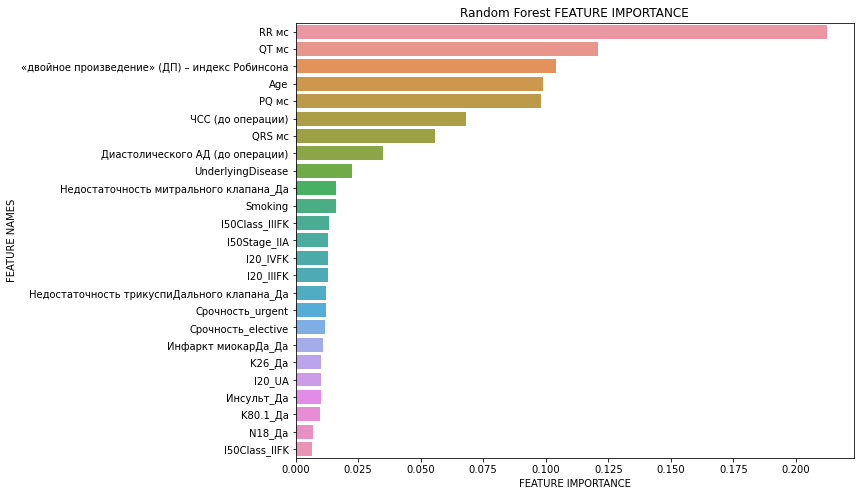

In [86]:
#### вывод Feature Importance, выбирать модель

def plot_feature_importance(importance, names, model_type):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

#Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
#plot_feature_importance(100.0 * (abs(model_fi.coef_[0]) / abs(model_fi.coef_[0]).max()), 
#                        X_train.columns, 
#                        'Logistic Regression Classifier')

plot_feature_importance(model_fi.feature_importances_, 
                        X_train.columns, 
                        'Random Forest')

In [87]:
model = testModel.best_estimator_

model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

[LibLinear]

In [88]:
df_clear_f['LAVolume']

0      43.722800
1      44.057520
2      38.660160
3      22.191936
4      24.802752
         ...    
880    35.799350
881    49.993047
882    45.607692
883    45.630704
885    73.592376
Name: LAVolume, Length: 801, dtype: float64

In [89]:
CatModel = CatBoostClassifier(random_state=SEED,
                              custom_loss=['AUC'],
                              random_strength=1,
                              iterations=500,
                              learning_rate=0.1,
                              depth=6
                             )

In [90]:
#paramsCat = [
#    {
#        'iterations': [500, 750],
#        'learning_rate': np.linspace(0.1, 1, 5),
#        'random_strength': range(1, 5, 1),
#        'bagging_temperature': range(0, 8, 2),
#        'depth': range(4, 10, 2),
        #'l2_leaf_reg': range(10, 15, 1),
        #'bootstrap_type': ['Bayesian', 'Bernoulli', None]
#    }
#]

In [749]:
testModel = GridSearchCV(CatModel,
                         param_grid=paramsCat,
                         cv=cv,
                         scoring='roc_auc',
                         verbose=True
                         )

In [91]:
CatModel.fit(X, y)

0:	learn: 0.6476863	total: 2.68ms	remaining: 1.34s
1:	learn: 0.6110885	total: 5.25ms	remaining: 1.31s
2:	learn: 0.5750711	total: 7.54ms	remaining: 1.25s
3:	learn: 0.5507568	total: 9.07ms	remaining: 1.12s
4:	learn: 0.5298642	total: 10.5ms	remaining: 1.04s
5:	learn: 0.5085233	total: 12ms	remaining: 987ms
6:	learn: 0.4860886	total: 13.3ms	remaining: 935ms
7:	learn: 0.4711045	total: 14.6ms	remaining: 898ms
8:	learn: 0.4553559	total: 15.9ms	remaining: 870ms
9:	learn: 0.4427504	total: 17.3ms	remaining: 848ms
10:	learn: 0.4296771	total: 19.3ms	remaining: 856ms
11:	learn: 0.4208731	total: 20.5ms	remaining: 832ms
12:	learn: 0.4127183	total: 21.8ms	remaining: 815ms
13:	learn: 0.3993191	total: 23ms	remaining: 798ms
14:	learn: 0.3902858	total: 24.2ms	remaining: 782ms
15:	learn: 0.3789981	total: 25.4ms	remaining: 770ms
16:	learn: 0.3712268	total: 26.7ms	remaining: 759ms
17:	learn: 0.3655192	total: 28.1ms	remaining: 751ms
18:	learn: 0.3630638	total: 29.3ms	remaining: 743ms
19:	learn: 0.3591871	total

In [92]:
print(testModel.best_score_)
print(testModel.best_params_)

0.6716980168269231
{'model': LogisticRegression(class_weight='balanced', penalty='l1', random_state=2031995,
                   solver='liblinear', verbose=True), 'model__C': 1.0, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'model__solver': 'liblinear'}


In [93]:
#model = testModel.best_estimator_

CatModel.fit(X_train, y_train)
y_proba = CatModel.predict_proba(X_test)
y_pred = CatModel.predict(X_test)

0:	learn: 0.6488980	total: 2.46ms	remaining: 1.23s
1:	learn: 0.6117054	total: 4.9ms	remaining: 1.22s
2:	learn: 0.5760267	total: 7.85ms	remaining: 1.3s
3:	learn: 0.5508503	total: 9.9ms	remaining: 1.23s
4:	learn: 0.5342542	total: 11.3ms	remaining: 1.12s
5:	learn: 0.5176305	total: 13.1ms	remaining: 1.07s
6:	learn: 0.4966808	total: 14.8ms	remaining: 1.04s
7:	learn: 0.4844956	total: 16.6ms	remaining: 1.02s
8:	learn: 0.4700708	total: 18.2ms	remaining: 995ms
9:	learn: 0.4577062	total: 19.9ms	remaining: 974ms
10:	learn: 0.4460007	total: 21.4ms	remaining: 954ms
11:	learn: 0.4373153	total: 23ms	remaining: 937ms
12:	learn: 0.4263108	total: 24.6ms	remaining: 922ms
13:	learn: 0.4164150	total: 26.2ms	remaining: 910ms
14:	learn: 0.4089571	total: 27.7ms	remaining: 897ms
15:	learn: 0.3984651	total: 29.2ms	remaining: 885ms
16:	learn: 0.3906221	total: 30.9ms	remaining: 879ms
17:	learn: 0.3838294	total: 32.3ms	remaining: 865ms
18:	learn: 0.3807987	total: 33.7ms	remaining: 853ms
19:	learn: 0.3749272	total:

In [94]:
#теоретический порог (до этого подбирала перебором) принятия решения классификатором по вероятности
fpr,tpr, thresholds = roc_curve(y_test, y_proba[:,1] , drop_intermediate = False)
print('Оптимальный порог для catboost:', np.round(thresholds.mean(), 3))
threshold_gridcatboost = np.round(thresholds.mean(), 3)


Оптимальный порог для catboost: 0.141


In [95]:
# функцию не нашла так что будет самопал
#print(y_proba)
#print(y_pred)

y_pred_thres = []
for row in y_proba[:,1]:
    if row >= threshold_gridcatboost:
        pred = 1
        y_pred_thres.append(pred)
    else:
        pred = 0
        y_pred_thres.append(pred)


In [96]:
print('ROC-AUC grid catboost soft output', roc_auc_score(y_test, y_proba[:,1]))
print('ROC-AUC grid rcatboost hard output with threshold', roc_auc_score(y_test, y_pred_thres))
print('ROC-AUC grid rcatboost hard output withot threshold', roc_auc_score(y_test, y_pred))
print('PRECISION grid rcatboost {} with treshold {}'.format(precision_score(y_test, y_pred_thres), threshold_gridcatboost))
print('RECALL grid rcatboost {} with treshold {}'.format(recall_score(y_test, y_pred_thres), threshold_gridcatboost))
print('F1-SCORE grid rcatboost', f1_score(y_test, y_pred_thres))

ROC-AUC grid catboost soft output 0.9182530795072787
ROC-AUC grid rcatboost hard output with threshold 0.8131765584173198
ROC-AUC grid rcatboost hard output withot threshold 0.8542366554684584
PRECISION grid rcatboost 0.39473684210526316 with treshold 0.141
RECALL grid rcatboost 0.7894736842105263 with treshold 0.141
F1-SCORE grid rcatboost 0.5263157894736843


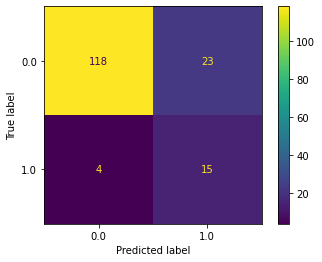

In [97]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_thres, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot() 
plt.show()

In [98]:
cm = confusion_matrix(y_test, y_pred_thres)

sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
specificity = cm[0,0]/(cm[0,0] + cm[0,1])

print('Чувствительность для grid catboost с порогом:', sensitivity)
print('Специфичность для grid catboost с порогом:', specificity)

Чувствительность для grid catboost с порогом: 0.7894736842105263
Специфичность для grid catboost с порогом: 0.8368794326241135


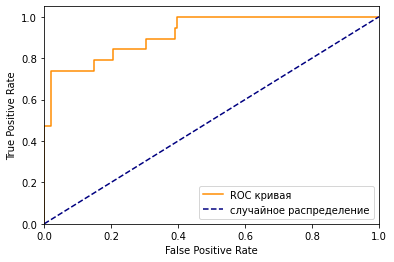

In [102]:
from sklearn.metrics import roc_curve, auc
fpr,tpr, thresholds = roc_curve(y_test, y_proba[:,1] , drop_intermediate = False)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
        label='ROC кривая' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', 
         label='случайное распределение')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC кривая для CatBoost')
plt.legend(loc="lower right")
plt.show()

### для картинок в диплом

In [103]:
def plot_feature_importance(importance,names,model_type):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

#Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

#Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    #fi_df = fi_df[0:21]

#Define size of bar plot
    plt.figure(figsize=(10,8))
#Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
#Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    

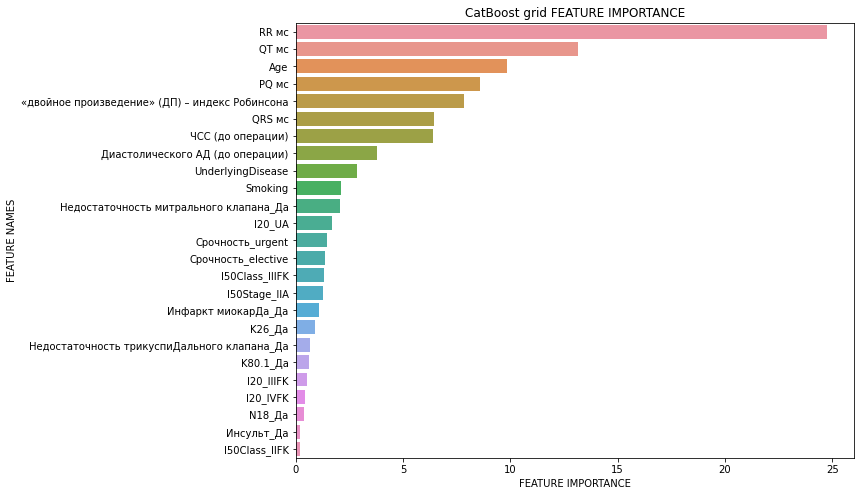

In [104]:
plot_feature_importance(CatModel.feature_importances_, 
                        X_train.columns, 
                        'CatBoost grid')

Таким образом, удалось показать комисии некоторые преимущества моделей машинного обучения перед шкалами стратификации. Так как шкалы изобретены органическими врачами, которые исходя из своего клинического опыта и кругозора предполагают возможные параметры пациента, которые могут заблаговременно подсказывать о предстоящих осложнениях. Данная оценка субъективна, и хотя может быть немного более завалидированна посредством статистической значимости, оценки шансов и когортных исследований все таки не исключает, что врач может упустить важный параметр пациента, или просто ине знать о нем.
Модель же способна увидеть скрытые закономерности, что может помочь аналитику выявить новые потенциальные предикторы. Кроме того, минимизации функции потерь, рассчитанная такими автоматическими методами позволяет вытащить максимум информации даже из менее значимых признаков, что позволяет выносить вердикт о последствиях для каждого конерктного пациента с использованием более простых в добыче данных (например, мои модели использовали характеристики ЭКГ, возраст, базовые анамнестические подробности о пациенте, тогда как клинические шкалы требуют анатомических подробностей камер и сосудов сердца (в случае SYNTAX), или более глубокого анамнеза (в случае EuroscoreII). 

## 4. Переобучение?
### Разные rabdom state

In [105]:
states = [SEED, 112263, 203, 9865, 6666, 100345]

In [106]:
proba_roc_auc_base = []
pred_roc_auc_base_thres = []
pred_roc_auc_base = []
precision_base = []
recall_base = []
f1_base = []
sensitivity_base = []
specificity_base = []


for state in states:
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=state)
    
    #X_train, y_train = upsample(X_train, y_train)
    
    model = CatBoostClassifier(random_state=state,
                               random_strength=1,
                               iterations=500,
                               bagging_temperature=0,
                               depth=6,
                               bootstrap_type= 'Bayesian',
                               l2_leaf_reg = 14)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    
    fpr,tpr, thresholds = roc_curve(y_test, y_proba[:,1] , drop_intermediate = False)
    print('Оптимальный порог для catboost:', np.round(thresholds.mean(), 3))
    threshold_gridcatboost = np.round(thresholds.mean(), 3)
    
    y_pred_thres = []
    for row in y_proba[:,1]:
        if row >= threshold_gridcatboost:
            pred = 1
            y_pred_thres.append(pred)
        else:
            pred = 0
            y_pred_thres.append(pred)
            
    proba_roc_auc_base.append(roc_auc_score(y_test, y_proba[:,1]))
    pred_roc_auc_base_thres.append(roc_auc_score(y_test, y_pred_thres))
    pred_roc_auc_base.append(roc_auc_score(y_test, y_pred))
    precision_base.append(precision_score(y_test, y_pred_thres))
    recall_base.append(recall_score(y_test, y_pred_thres))
    f1_base.append(f1_score(y_test, y_pred_thres))
    
    cm = confusion_matrix(y_test, y_pred_thres)
    sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
    sensitivity_base.append(sensitivity)
    specificity = cm[0,0]/(cm[0,0] + cm[0,1])
    specificity_base.append(specificity)

0:	learn: 0.6797214	total: 1.47ms	remaining: 734ms
1:	learn: 0.6658706	total: 3.26ms	remaining: 813ms
2:	learn: 0.6543049	total: 4.47ms	remaining: 741ms
3:	learn: 0.6419666	total: 5.65ms	remaining: 701ms
4:	learn: 0.6329960	total: 6.89ms	remaining: 683ms
5:	learn: 0.6243320	total: 8.28ms	remaining: 682ms
6:	learn: 0.6137260	total: 9.65ms	remaining: 679ms
7:	learn: 0.6043259	total: 10.9ms	remaining: 673ms
8:	learn: 0.5955083	total: 12.4ms	remaining: 674ms
9:	learn: 0.5869675	total: 14.2ms	remaining: 694ms
10:	learn: 0.5790694	total: 15.6ms	remaining: 694ms
11:	learn: 0.5725030	total: 16.9ms	remaining: 688ms
12:	learn: 0.5669475	total: 18.3ms	remaining: 687ms
13:	learn: 0.5595085	total: 19.7ms	remaining: 685ms
14:	learn: 0.5514459	total: 21ms	remaining: 678ms
15:	learn: 0.5436230	total: 22.3ms	remaining: 675ms
16:	learn: 0.5391694	total: 23.6ms	remaining: 670ms
17:	learn: 0.5337984	total: 24.9ms	remaining: 668ms
18:	learn: 0.5276699	total: 26.3ms	remaining: 666ms
19:	learn: 0.5224998	tot

In [107]:
def display_mean_metric(metric, metric_name):
    print('{}: {}'.format(metric_name, pd.Series(metric).mean()))

In [108]:
metric_names = (proba_roc_auc_base, 
                pred_roc_auc_base_thres, 
                pred_roc_auc_base, 
                precision_base, 
                recall_base,
                f1_base, 
                sensitivity_base, 
                specificity_base)
str_metric_names = ['proba_roc_auc_base', 
                    'pred_roc_auc_base_thres', 
                    'pred_roc_auc_base', 
                    'precision_base', 
                    'recall_base',
                    'f1_base', 
                    'sensitivity_base', 
                    'specificity_base']

In [109]:
## запуск без апсемплинга
for metric, metric_name in zip(metric_names, str_metric_names):
    display_mean_metric(metric, metric_name)

proba_roc_auc_base: 0.8559898312748236
pred_roc_auc_base_thres: 0.7841073123391382
pred_roc_auc_base: 0.6312372296877838
precision_base: 0.4600223298226808
recall_base: 0.7709435661595592
f1_base: 0.5717371699684223
sensitivity_base: 0.7709435661595592
specificity_base: 0.7972710585187172


In [110]:
## заупуск с апсемплингом
for metric, metric_name in zip(metric_names, str_metric_names):
    display_mean_metric(metric, metric_name)

proba_roc_auc_base: 0.8559898312748236
pred_roc_auc_base_thres: 0.7841073123391382
pred_roc_auc_base: 0.6312372296877838
precision_base: 0.4600223298226808
recall_base: 0.7709435661595592
f1_base: 0.5717371699684223
sensitivity_base: 0.7709435661595592
specificity_base: 0.7972710585187172


### Контроллируемая CrossValidation
Была проведена кроссвалидация на 20 фолдах с целью выявить аномальные объекты, которые, исчезая из обучающей выборки и появлясь в тестовой портили скор. 

In [111]:


df1 = df_selected_f.sort_values(by='fibrillation_a')
times_10_folds = len(df1)/20
df1['fold_num'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] * int(times_10_folds)

In [112]:
#df1.query('fold_num == 10').index.sort_values()

In [113]:
def cross_val_all_metrics(df, model, test_fold_num): #датасет, модель, номер тестового фолда, куда заносить результат
    train = df.query('fold_num != @test_fold_num')
    #loc[df['fold_num'] == !test_fold_num]
    test = df.query('fold_num == @test_fold_num')
    #loc[df['fold_num'] == test_fold_num]
    
    X_train = train.drop(['fold_num', 'fibrillation_a'], axis=1)
    y_train = train['fibrillation_a']
    X_test = test.drop(['fold_num', 'fibrillation_a'], axis=1)
    y_test = test['fibrillation_a']
    
    CatModel.fit(X_train, y_train)
    y_proba = CatModel.predict_proba(X_test)
    y_pred = CatModel.predict(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1] , drop_intermediate = False)
    print('Оптимальный порог для catboost:', np.round(thresholds.mean(), 3))
    threshold = np.round(thresholds.mean(), 3)
    
    y_pred_thres = []
    for row in y_proba[:,1]:
        if row >= threshold:
            pred = 1
            y_pred_thres.append(pred)
        else:
            pred = 0
            y_pred_thres.append(pred)
            
    proba_roc_auc = roc_auc_score(y_test, y_proba[:,1])
    pred_roc_auc_thresh = roc_auc_score(y_test, y_pred_thres)
    pred_roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred_thres)
    recall = recall_score(y_test, y_pred_thres)
    f1 = f1_score(y_test, y_pred_thres)
    
    cm = confusion_matrix(y_test, y_pred_thres)
    sensitivity = cm[1,1]/(cm[1,1] + cm[1,0])
    specificity = cm[0,0]/(cm[0,0] + cm[0,1])
    
    return proba_roc_auc, pred_roc_auc_thresh, pred_roc_auc, precision, recall, f1, sensitivity, specificity

In [114]:
results = pd.DataFrame(index = ['proba_roc_auc', 'pred_roc_auc_thresh', 'pred_roc_auc', 'precision', 
                                  'recall', 'f1', 'sensitivity', 'specificity'],
                       columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

#index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  #


In [115]:
for i in range(1, 21):
    results[i] = cross_val_all_metrics(df1, model, i)

0:	learn: 0.6480388	total: 2.42ms	remaining: 1.21s
1:	learn: 0.6117652	total: 3.83ms	remaining: 954ms
2:	learn: 0.5769279	total: 5.8ms	remaining: 961ms
3:	learn: 0.5472140	total: 7.1ms	remaining: 880ms
4:	learn: 0.5270749	total: 7.93ms	remaining: 785ms
5:	learn: 0.4998746	total: 9.03ms	remaining: 743ms
6:	learn: 0.4791323	total: 10.3ms	remaining: 723ms
7:	learn: 0.4625795	total: 11.5ms	remaining: 705ms
8:	learn: 0.4485557	total: 12.6ms	remaining: 686ms
9:	learn: 0.4320353	total: 13.9ms	remaining: 681ms
10:	learn: 0.4207466	total: 15.1ms	remaining: 673ms
11:	learn: 0.4117014	total: 16.3ms	remaining: 661ms
12:	learn: 0.4005597	total: 17.4ms	remaining: 652ms
13:	learn: 0.3895716	total: 18.6ms	remaining: 645ms
14:	learn: 0.3812174	total: 19.8ms	remaining: 641ms
15:	learn: 0.3698665	total: 21ms	remaining: 636ms
16:	learn: 0.3610515	total: 22.3ms	remaining: 633ms
17:	learn: 0.3518443	total: 23.4ms	remaining: 627ms
18:	learn: 0.3490100	total: 24.6ms	remaining: 622ms
19:	learn: 0.3468248	total

In [116]:
results = results.T

In [1289]:
results ### выводы всех метрик по фолдам

,proba_roc_auc,pred_roc_auc_thresh,pred_roc_auc,precision,recall,f1,sensitivity,specificity
1,0.913420,0.781385,0.627706,0.500000,0.714286,0.588235,0.714286,0.848485
2,0.878788,0.796537,0.785714,0.555556,0.714286,0.625000,0.714286,0.878788
3,0.731602,0.623377,0.612554,0.333333,0.428571,0.375000,0.428571,0.818182
4,0.787879,0.740260,0.785714,0.571429,0.571429,0.571429,0.571429,0.909091
5,0.857143,0.811688,0.785714,0.625000,0.714286,0.666667,0.714286,0.909091
6,0.909091,0.725108,0.699134,0.500000,0.571429,0.533333,0.571429,0.878788
7,0.982684,0.969697,0.785714,0.777778,1.000000,0.875000,1.000000,0.939394
8,0.913420,0.781385,0.571429,0.500000,0.714286,0.588235,0.714286,0.848485
9,0.976562,0.890625,0.937500,0.700000,0.875000,0.777778,0.875000,0.906250
10,0.867188,0.843750,0.859375,0.750000,0.750000,0.750000,0.750000,0.937500


In [117]:
print(results['proba_roc_auc'].mean())

0.8338575487012987


Таким образом, наиболее проблемными оказались фолды 13(ROC-AUC = 0.66), 18 (ROC-AUC = 0.64). Индексы объектов, оказавшиеся в этих фолдах выведены ниже.
Подобный жксперимен на 10 фолдах показывает 4 фолда с аномально низким скором, что может говорить о точечных "проблемных объектах".

## 5. Попытка воспроизвести клиническую шкалу

EuroscoreII - клиническая шкала стратификации рисков внутригоспитальной смерти после АКШ, модель на основе логистической регрессии. В основной статье есть данные ои весах каждого параметра, а ее валидация проводилась на 5000+ пациентах. Поэтому былло решено попробовать ее результаты предсказания на этих данных.

In [118]:
### proper features
#female
df_clear_f['female'] = np.nan
df_clear_f['male'] = df_clear['male']
df_clear_f.loc[df_clear_f['male'] == 1, 'female'] = 0
df_clear_f.loc[df_clear_f['male'] == 0, 'female'] = 1

# креатинин
df_clear_f['Креатинин1'] = df['Креатинин1']

df_clear_f['Креатинин>=200'] = np.nan
df_clear_f.loc[df_clear_f['Креатинин1'] >= 200, 'Креатинин>=200'] = 1
df_clear_f.loc[~(df_clear_f['Креатинин1'] >= 200), 'Креатинин>=200'] = 0

df_clear_f['Креатинин90-110'] = np.nan
df_clear_f.loc[(df_clear_f['Креатинин1'] >= 90) & (df_clear_f['Креатинин1'] < 110), 'Креатинин90-110'] = 1
df_clear_f.loc[~((df_clear_f['Креатинин1'] >= 90) & (df_clear_f['Креатинин1'] < 110)), 'Креатинин90-110'] = 0

df_clear_f['Креатинин110-130'] = np.nan
df_clear_f.loc[(df_clear_f['Креатинин1'] >= 110) & (df_clear_f['Креатинин1'] <130), 'Креатинин110-130'] = 1
df_clear_f.loc[~((df_clear_f['Креатинин1'] >= 110) & (df_clear_f['Креатинин1'] <130)), 'Креатинин110-130'] = 0

df_clear_f['Креатинин130-200'] = np.nan
df_clear_f.loc[(df_clear_f['Креатинин1'] >= 130) & (df_clear_f['Креатинин1'] < 200), 'Креатинин130-200'] = 1
df_clear_f.loc[~((df_clear_f['Креатинин1'] >= 130) & (df_clear_f['Креатинин1'] < 200)), 'Креатинин130-200'] = 0

## EF%(b)
df_clear_f['LVEF<30'] = np.nan
df_clear_f.loc[df_clear_f['EF%(b)'] < 30, 'LVEF<30'] = 1
df_clear_f.loc[~(df_clear_f['EF%(b)'] < 30), 'LVEF<30'] = 0

df_clear_f['LVEF30-50'] = np.nan
df_clear_f.loc[(df_clear_f['EF%(b)'] >= 30) & (df_clear_f['EF%(b)'] <= 50), 'LVEF30-50'] = 1
df_clear_f.loc[~((df_clear_f['EF%(b)'] >= 30) & (df_clear_f['EF%(b)'] <= 50)), 'LVEF30-50'] = 1

df_clear_f['LVEF20-30'] = np.nan
df_clear_f.loc[(df_clear_f['EF%(b)'] >= 20) & (df_clear_f['EF%(b)'] < 30), 'LVEF20-30'] = 1
df_clear_f.loc[~((df_clear_f['EF%(b)'] >= 20) & (df_clear_f['EF%(b)'] < 30)), 'LVEF20-30'] = 1

df_clear_f['LVEF<20'] = np.nan
df_clear_f.loc[df_clear_f['EF%(b)'] < 20, 'LVEF<20'] = 1
df_clear_f.loc[~(df_clear_f['EF%(b)'] < 20), 'LVEF<20'] = 0

## PAP
df_clear_f['PAP>60'] = np.nan
df_clear_f.loc[df_clear_f['PAP'] > 60, 'PAP>60'] = 1
df_clear_f.loc[~(df_clear_f['PAP'] > 60), 'PAP>60'] = 0

df_clear_f['PAP20-60'] = np.nan
df_clear_f.loc[(df_clear_f['PAP'] >= 20) & (df_clear_f['PAP'] <= 60), 'PAP20-60'] = 1
df_clear_f.loc[~((df_clear_f['PAP'] >= 20) & (df_clear_f['PAP'] <= 60)), 'PAP20-60'] = 1

# Операция на грудной аорте
df_clear_f['Операция на грудной аорте'] = df['Операция на грудной аорте']
df_clear_f.loc[df_clear_f['Операция на грудной аорте'] == 'Нет', 'Операция на грудной аорте'] = 0
df_clear_f.loc[df_clear_f['Операция на грудной аорте'] == 'Да', 'Операция на грудной аорте'] = 1





In [119]:
# сопоставимые признаки
euroscore_feats = ['Age', 
                   'female', 
                   'Экстракардиальная артериопатия', 
                   'J44', 
                   'Плохая мобильность',
                   'Операция на сердце в анамнезе',
                   'Креатинин>=200',
                   'Креатинин90-110',
                   'Креатинин110-130',
                   'Креатинин130-200',
                   'Активный эндокардит',
                   'Критическое предоперационное состояние',
                   'I20_IVFK',
                   'LVEF<30',
                   'LVEF30-50',
                   'LVEF20-30',
                   'LVEF<20',
                   'PAP>60',
                   'PAP20-60',
                   'Срочность_emergency',
                   'Операция на грудной аорте']
                   #'fibrillationa_a']


In [120]:
#df_clear_f['Критическое предоперационное состояние']

In [121]:
# sample weights
euroscore_weights = { 'Age' : 0.0486477, 
                    'female' : 0.3951561, 
                    'Экстракардиальная артериопатия' : 0.7637420, 
                    'J44' : 0.4544856, 
                    'Плохая мобильность' : 0.7644773,
                   'Операция на сердце в анамнезе' : 1.281896,
                   'Креатинин>=200' : 1.5384690, 
                   'Креатинин90-110' : 0.2218056,
                   'Креатинин110-130' : 0.7177771,
                   'Креатинин130-200' : 1.2135250,
                   'Активный эндокардит' : 1.4029890,
                   'Критическое предоперационное состояние' : 2.1827250,
                   'I20_IVFK' : 0.8217379,
                   'LVEF<30' : 1.4371450,
                   'LVEF30-50' : 0.4626558,
                   'LVEF20-30' : 1.5041660,
                   'LVEF<20' : 1.6481420,
                   'PAP>60' : 0.7201059,
                   'PAP20-60' : 0.1647881,
                   'Срочность_emergency' : 1.8999760,
                   'Операция на грудной аорте' : 1.1809770,
                   'intercept' : -5.324537
                    }

few = { 'intercept' : -5.324537,
       'Age' : 0.0285181, 
       'female' : 0.2196434, 
       'Экстракардиальная артериопатия' : 0.5360268, 
       'J44' : 0.1886564, 
       'Плохая мобильность' : 0.2407181,
       'Операция на сердце в анамнезе' : 1.118599,
       'Креатинин>=200' : 1.5384690, 
       'Креатинин90-110' : 0.2218056,
       'Креатинин110-130' : 0.7177771,
       'Креатинин130-200' : 1.2135250,
       'Активный эндокардит' : 0.6194522,
       'Критическое предоперационное состояние' : 1.086517,
       'I20_IVFK' : 0.8217379,
       'LVEF<30' : 1.4371450,
       'LVEF30-50' : 0.4626558,
       'LVEF20-30' : 1.5041660,
       'LVEF<20' : 1.6481420,
       'PAP>60' : 0.7201059,
       'PAP20-60' : 0.1647881,
       'Срочность_emergency' : 0.7039121,
       'Операция на грудной аорте' : 1.1809770
        }

euroscore_weights_list = [0.0486477, 0.3951561, 0.7637420, 0.4544856, 0.7644773, 1.281896, 1.5384690, 0.2218056,
                          0.7177771, 1.2135250, 1.4029890, 2.1827250, 0.8217379, 1.4371450, 0.4626558, 1.5041660,
                          1.6481420, 0.7201059, 0.1647881, 1.8999760, 1.1809770]

In [122]:
df['Срочность'].value_counts()

elective     616
urgent       234
emergency     30
 urgent        1
Name: Срочность, dtype: int64

In [123]:
euroscore_df = df_clear_f[euroscore_feats].dropna()
euroscore_df['fibrillation_a'] = df_clear_f['fibrillation_a'].dropna()
euroscore_df = euroscore_df.dropna()


In [124]:
euroscore_df.isna().sum()

Age                                       0
female                                    0
Экстракардиальная артериопатия            0
J44                                       0
Плохая мобильность                        0
Операция на сердце в анамнезе             0
Креатинин>=200                            0
Креатинин90-110                           0
Креатинин110-130                          0
Креатинин130-200                          0
Активный эндокардит                       0
Критическое предоперационное состояние    0
I20_IVFK                                  0
LVEF<30                                   0
LVEF30-50                                 0
LVEF20-30                                 0
LVEF<20                                   0
PAP>60                                    0
PAP20-60                                  0
Срочность_emergency                       0
Операция на грудной аорте                 0
fibrillation_a                            0
dtype: int64

In [125]:
EX = euroscore_df.drop(['fibrillation_a'], axis=1)
Ey = euroscore_df['fibrillation_a']

EX_train, EX_test, Ey_train, Ey_test = train_test_split(EX, 
                                                    Ey, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=SEED)

In [126]:
EX

,Age,female,Экстракардиальная артериопатия,J44,Плохая мобильность,Операция на сердце в анамнезе,Креатинин>=200,Креатинин90-110,Креатинин110-130,Креатинин130-200,...,Критическое предоперационное состояние,I20_IVFK,LVEF<30,LVEF30-50,LVEF20-30,LVEF<20,PAP>60,PAP20-60,Срочность_emergency,Операция на грудной аорте
0,69,0.0,1,1,0,0,0.0,0.0,1.0,0.0,...,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0,0
1,77,0.0,1,1,0,0,0.0,1.0,0.0,0.0,...,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0,0
2,70,1.0,1,0,0,0,0.0,1.0,0.0,0.0,...,0,1,0.0,1.0,1.0,0.0,0.0,1.0,0,0
3,66,0.0,1,0,0,0,0.0,1.0,0.0,0.0,...,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0,0
4,56,0.0,0,1,0,0,0.0,0.0,0.0,0.0,...,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,65,0.0,0,0,0,0,0.0,0.0,0.0,1.0,...,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0,0
881,70,0.0,1,1,0,0,0.0,0.0,0.0,0.0,...,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0,0
882,59,0.0,1,0,0,0,0.0,0.0,0.0,1.0,...,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0,0
883,70,0.0,1,0,0,0,0.0,0.0,0.0,1.0,...,0,0,0.0,1.0,1.0,0.0,0.0,1.0,0,0


In [127]:
EuroscoreII = LogisticRegression(random_state=SEED, fit_intercept = False, class_weight = euroscore_weights)
EuroscoreII.coef_ = np.array([euroscore_weights_list])
EuroscoreII.intercept_ = -6
EuroscoreII.classes_ = np.array([0, 1])



In [128]:
eu_proba = EuroscoreII.predict_proba(np.array(EX))
eu_pred = EuroscoreII.predict(np.array(EX))

In [129]:
#print('ROC-AUC Regression soft output', roc_auc_score(Ey, eu_proba[:,1]))
#print(roc_auc_score(Ey, eu_pred))
#print('ROC-AUC Regression hard output', roc_auc_score(y_test, y_pred))

In [130]:
pd.DataFrame(Ey).isna().sum()

fibrillation_a    0
dtype: int64

In [131]:
#y_pred_thres = []
#for row in eu_proba[:,1]:
    #print(row)
#    if row >= 0.345:
#        pred = 1
#        y_pred_thres.append(pred)
#    else:
#        pred = 0
#        y_pred_thres.append(pred)
        
        
        
print('ROC-AUC EuroscoreII soft output', roc_auc_score(Ey, eu_proba[:,1]))
#print('ROC-AUC EuroscoreII soft output with threshold', roc_auc_score(Ey_test, y_pred_thres))
#print('ROC-AUC grid rcatboost hard output withot threshold', roc_auc_score(y_test, y_pred))
#print('PRECISION EuroscoreII {} with treshold {}'.format(precision_score(y_test, y_pred_thres), threshold_gridcatboost))
#print('RECALL EuroscoreII {} with treshold {}'.format(recall_score(y_test, y_pred_thres), threshold_gridcatboost))
#print('F1-SCORE Euroscore', f1_score(y_test, y_pred_thres))

ROC-AUC EuroscoreII soft output 0.569148821345307


К сожалению, признаков, доступных в местном датасете не достаточно, чтобы воспроизвести шкалу полноценно. Качество ее предсказаний крайне низкое.

##### Другой способ, совсем вручную

In [132]:
def EuroscoreII_f(row):
    p_sum = 0
    for name in euroscore_feats:
        p_sum += few[name]*row[name]
    prob = 1 / (1 + np.exp(-(few['intercept'] + p_sum)))
    return prob

In [133]:
eu_proba1 = EX.apply(EuroscoreII_f, axis=1)

In [134]:
print(eu_proba1)
print(eu_proba[:,1])

0      0.554108
1      0.487367
2      0.646240
3      0.365192
4      0.196667
         ...   
880    0.468610
881    0.384148
882    0.559515
883    0.634806
885    0.420982
Length: 774, dtype: float64
[0.80601256 0.78876814 0.85060963 0.58124971 0.33411465 0.56677361
 0.81968516 0.49071102 0.41781994 0.85405959 0.33859083 0.85871943
 0.92037944 0.80615983 0.38767956 0.55133802 0.93959908 0.32569471
 0.76382385 0.67405472 0.29796457 0.56247332 0.35119951 0.57701597
 0.36009135 0.44232018 0.92031159 0.43035603 0.77577557 0.53978216
 0.50220116 0.84025935 0.94154012 0.51585141 0.85092374 0.30021837
 0.93976998 0.62415816 0.28448678 0.70422369 0.36732957 0.73828757
 0.42283809 0.8007006  0.41761631 0.45879605 0.7579899  0.60579326
 0.7606619  0.49071102 0.36978677 0.38513053 0.91094084 0.93841958
 0.406036   0.63334924 0.36070976 0.36485067 0.41616395 0.46407449
 0.61347826 0.68389058 0.27897973 0.88904445 0.55709982 0.30021837
 0.57867761 0.28886961 0.43199081 0.24658599 0.73369198 0.3

In [135]:
print('ROC-AUC EuroscoreII soft output', roc_auc_score(Ey, eu_proba1))

ROC-AUC EuroscoreII soft output 0.560492401347034


In [ ]:
... и все так же плохо.

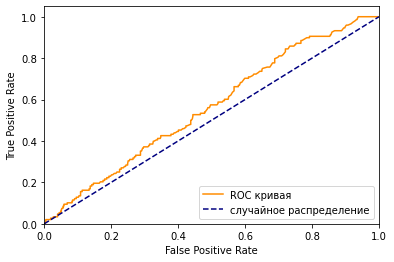

In [136]:
fpr,tpr, thresholds = roc_curve(Ey, eu_proba1 , drop_intermediate = False)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
        label='ROC кривая' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', 
         label='случайное распределение')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('ROC кривая для CatBoost')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#xi_list = [x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22]
#wxi_list = list(wx1, wx2, wx3, wx3, wx4, wx5, wx6, wx7, wx8, wx9, wx10, wx11, wx12, wx13, wx14, wx15, wx16, wx17, wx18, wx19, wx20, wx21, wx22)

intercept = -5.324537
for xi, x in zip(xi_list, few):
    xi = x


## 0. Всякий добавочный функционал для заполнения табличек в диплом

In [137]:
topfeats

Index(['QRS мс', 'QT мс', 'I50Class_IIIFK',
       'Недостаточность трикуспиДального клапана_Да', 'Age', 'Smoking',
       'Срочность_elective', 'Инфаркт миокарДа_Да', 'Инсульт_Да',
       'Срочность_urgent', 'I50Class_IIFK', 'I20_IVFK',
       'Недостаточность митрального клапана_Да', 'I20_UA', 'I50Stage_IIA',
       'PQ мс', 'ЧСС (до операции)', 'K80.1_Да', 'I20_IIIFK',
       'Диастолического АД (до операции)', 'K26_Да', 'RR мс',
       '«двойное произведение» (ДП) – индекс Робинсона', 'UnderlyingDisease',
       'N18_Да'],
      dtype='object')

In [138]:
import statsmodels.stats.api as sms # импорт тут чтобы не выполнять весь ноутбук с лесами и градиентами когда срочно надо проверить

sms.DescrStatsW(df_clear_f['RA1'].dropna()).tconfint_mean()

(3.7416648877853307, 3.8262915154844226)

In [139]:
import numpy as np # та же
import scipy.stats # причина


def median_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.median(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [140]:
median_confidence_interval(df_selected_f['«двойное произведение» (ДП) – индекс Робинсона'].dropna())

(88.4, 86.9875165547152, 89.81248344528481)